# Clean Data Analysis

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats
from sklearn.metrics import pairwise
from sklearn.metrics import mean_squared_error

import statsmodels.tsa.seasonal as smt

In [2]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams.update({"font.size": 18})

# Load Data

In [3]:
data_folder = os.path.join("..", "..", "data", "tarragona")

clean_data_folder = os.path.join(data_folder, "clean_data")

correlation_folder = os.path.join(data_folder, "correlation_timeseries")

variation_folder = os.path.join(data_folder, "daily_variation_by_year")

trend_folder = os.path.join(data_folder, "trend")

In [4]:
tortosa_df = pd.read_excel(
    os.path.join(clean_data_folder, "tortosa.xlsx")
)
guiamets_df = pd.read_excel(
    os.path.join(clean_data_folder, "guiamets.xlsx")
)
mequinenza_df = pd.read_excel(
    os.path.join(clean_data_folder, "mequinenza.xlsx")
)
xerta_df = pd.read_excel(os.path.join(clean_data_folder, "xerta.xlsx"))

In [5]:
# use same time period for all data
min_date = max(
    tortosa_df["DateTime"].min(),
    guiamets_df["DateTime"].min(),
    mequinenza_df["DateTime"].min(),
    xerta_df["DateTime"].min(),
)
max_date = min(
    tortosa_df["DateTime"].max(),
    guiamets_df["DateTime"].max(),
    mequinenza_df["DateTime"].max(),
    xerta_df["DateTime"].max(),
)

tortosa_df = tortosa_df[
    (tortosa_df["DateTime"] >= min_date)
    & (tortosa_df["DateTime"] <= max_date)
]
guiamets_df = guiamets_df[
    (guiamets_df["DateTime"] >= min_date)
    & (guiamets_df["DateTime"] <= max_date)
]
mequinenza_df = mequinenza_df[
    (mequinenza_df["DateTime"] >= min_date)
    & (mequinenza_df["DateTime"] <= max_date)
]
xerta_df = xerta_df[
    (xerta_df["DateTime"] >= min_date)
    & (xerta_df["DateTime"] <= max_date)
]

# Compare common variables

Common variables are:
* cumulated_rainfall_24h
* watertemperature
* conductivity

The idea is to combine every variable in a single dataset, which in this case is the Xerta dataset, firstly by comparing the redundant variables between each site and secondly by merging the selected variables into the Xerta df.

To compare common variables, the same time period must be used.

## Cumulated Rainfall

In [6]:
common_variable = "cumulated_rainfall_24h"

In [7]:
%%script false --no-raise-error
# get common datetimes where both tortosa_df and guiamets_df have positive values
common_datetimes = tortosa_df[
    (tortosa_df[common_variable] > 0)
    & (guiamets_df[common_variable] > 0)
]["DateTime"]

tortosa_df = tortosa_df[
    tortosa_df["DateTime"].isin(common_datetimes)
].sort_values("DateTime")

guiamets_df = guiamets_df[
    guiamets_df["DateTime"].isin(common_datetimes)
].sort_values("DateTime")


<Axes: xlabel='DateTime', ylabel='cumulated_rainfall_24h'>

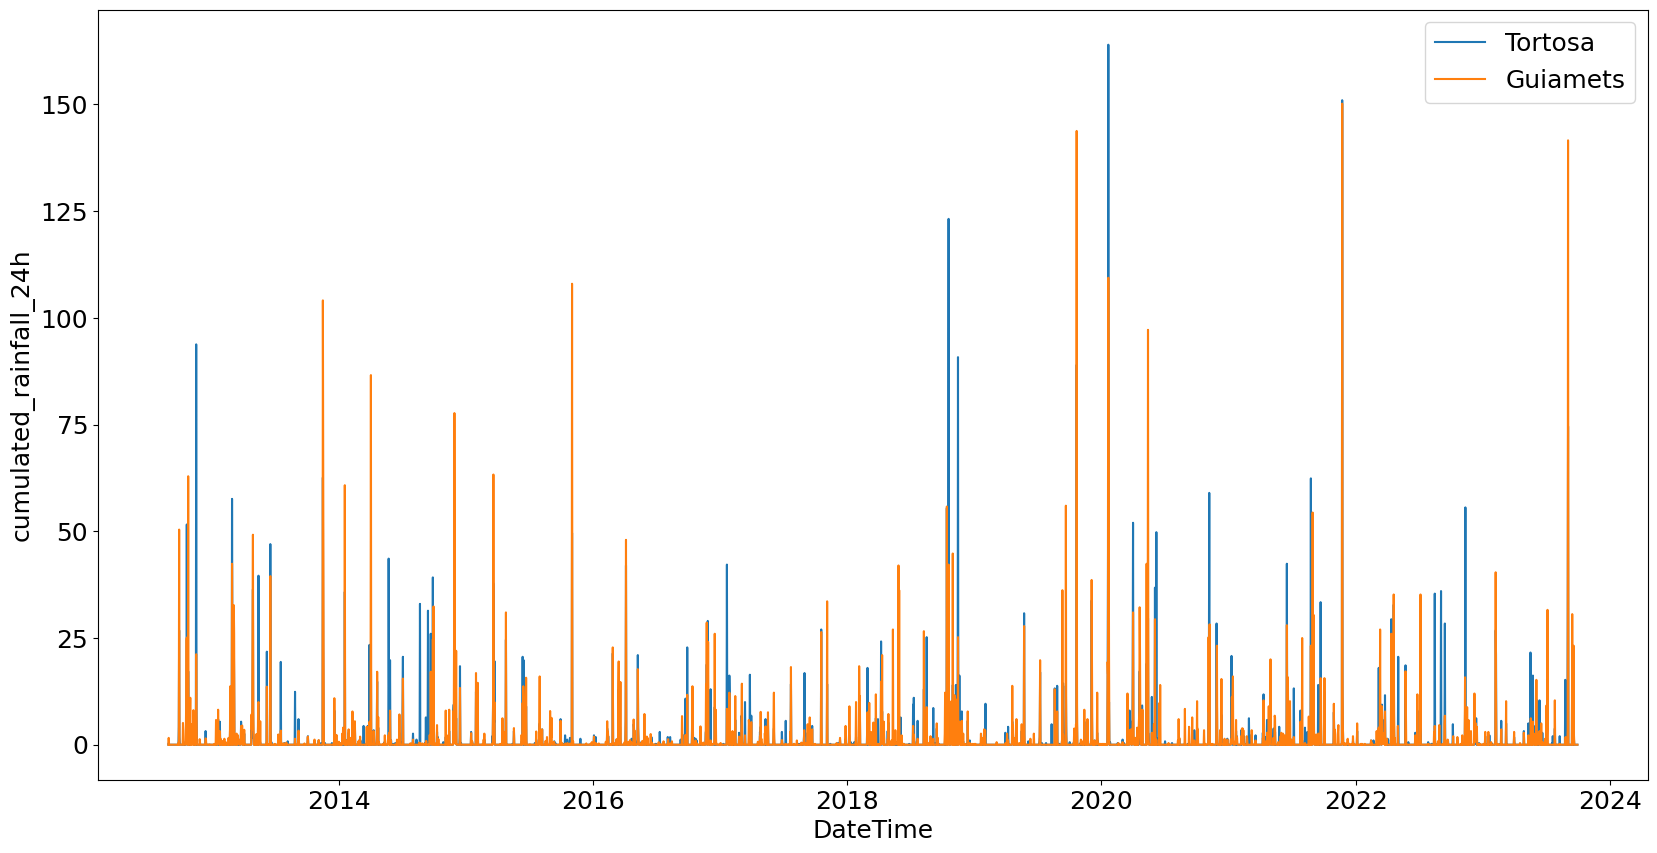

In [8]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=guiamets_df, label="Guiamets"
)
# sns.lineplot(
#     x="DateTime",
#     y=common_variable,
#     data=mequinenza_df,
#     label="Mequinenza",
# )

### Pearson

#### Tortosa - Mequinenza

In [9]:
stats.pearsonr(
    tortosa_df[common_variable],
    mequinenza_df[common_variable],
)

PearsonRResult(statistic=0.5298922299610764, pvalue=4.518207997437625e-292)

#### Tortosa - Guiamets

In [10]:
pears, _ = stats.pearsonr(
    tortosa_df[common_variable],
    guiamets_df[common_variable],
)

#### Mequinenza - Guiamets

In [11]:
stats.pearsonr(
    mequinenza_df[common_variable], guiamets_df[common_variable]
)

PearsonRResult(statistic=0.6443444415028019, pvalue=0.0)

### Cosine Similarity

#### Tortosa - Mequinenza

In [12]:
pairwise.cosine_similarity(
    tortosa_df[common_variable].values.reshape(1, -1),
    mequinenza_df[common_variable].values.reshape(1, -1),
)

array([[0.54925868]])

#### Tortosa - Guiamets

In [13]:
pairwise.cosine_similarity(
    tortosa_df[common_variable].values.reshape(1, -1),
    guiamets_df[common_variable].values.reshape(1, -1),
)

array([[0.76018873]])

#### Mequinenza - Guiamets

In [14]:
pairwise.cosine_similarity(
    mequinenza_df[common_variable].values.reshape(1, -1),
    guiamets_df[common_variable].values.reshape(1, -1),
)

array([[0.65949594]])

### RMSE

#### Tortosa - Mequinenza

In [15]:
rmse = np.sqrt(
    mean_squared_error(
        tortosa_df[common_variable], mequinenza_df[common_variable]
    )
)
rmse / np.std(tortosa_df[common_variable])

0.8505227582426494

#### Tortosa - Guiamets

In [16]:
rmse = np.sqrt(
    mean_squared_error(
        tortosa_df[common_variable], guiamets_df[common_variable]
    )
)
rmse / np.std(tortosa_df[common_variable])

0.7338910452422557

### Kendall-Tau

#### Tortosa - Mequinenza

In [17]:
stats.kendalltau(
    tortosa_df[common_variable], mequinenza_df[common_variable]
)

SignificanceResult(statistic=0.5407433541402125, pvalue=0.0)

#### Tortosa - Guiamets

In [18]:
stats.kendalltau(
    tortosa_df[common_variable], guiamets_df[common_variable]
)

SignificanceResult(statistic=0.6567552775323721, pvalue=0.0)

#### Mequinenza - Guiamets

In [19]:
stats.kendalltau(
    mequinenza_df[common_variable], guiamets_df[common_variable]
)

SignificanceResult(statistic=0.6287563547252626, pvalue=0.0)

### Plot

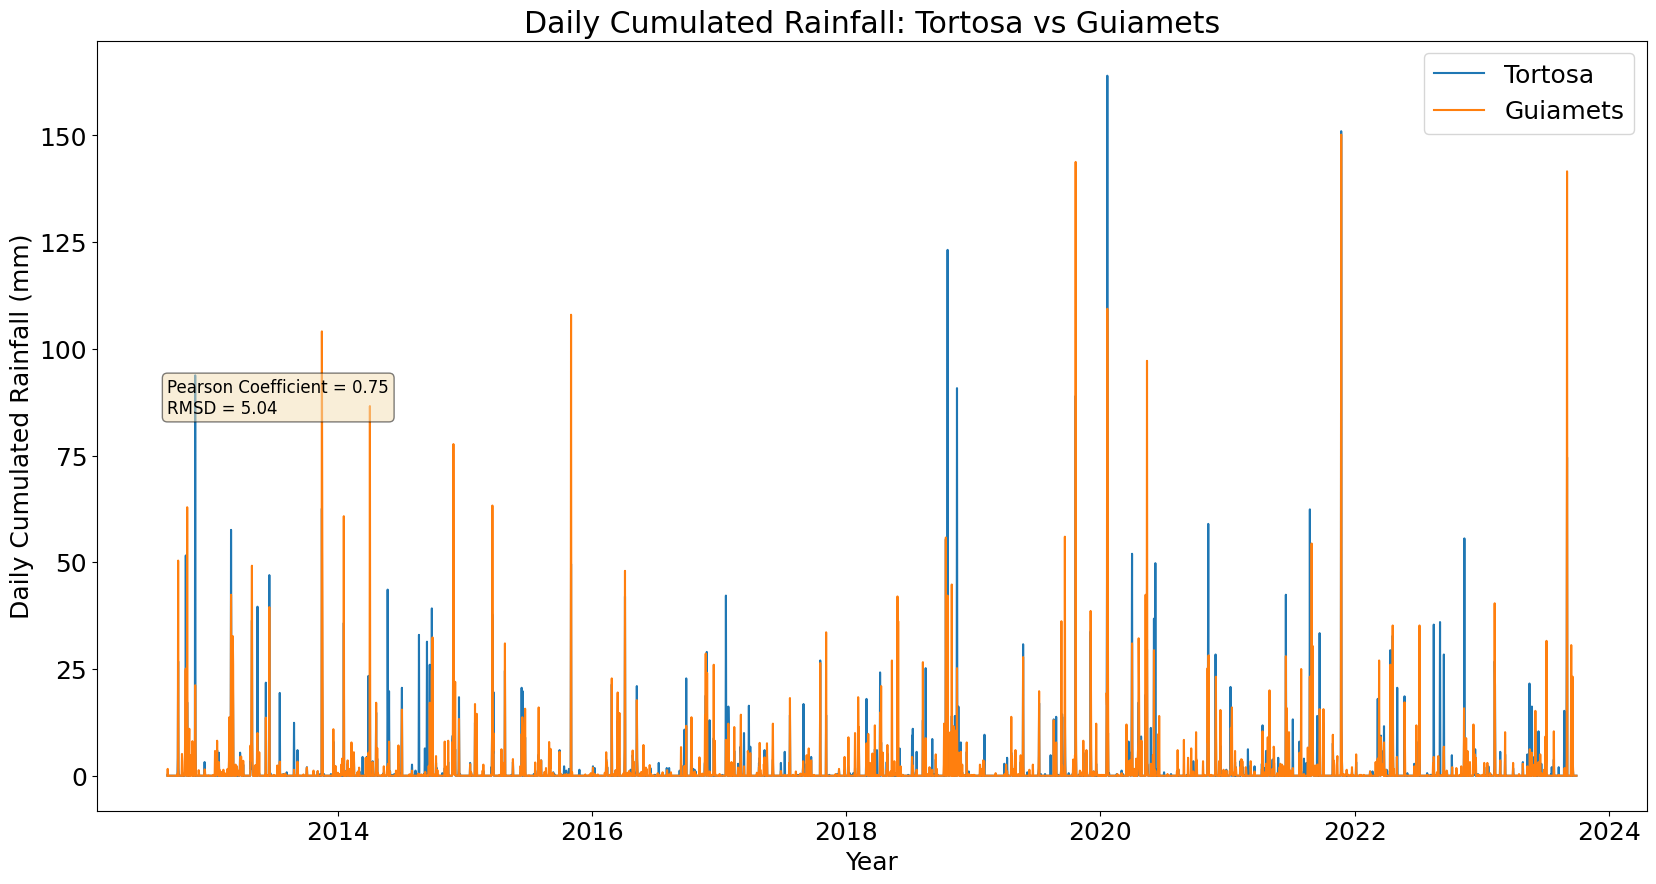

In [20]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=guiamets_df, label="Guiamets"
)
# sns.lineplot(
#     x="DateTime",
#     y=common_variable,
#     data=mequinenza_df,
#     label="Mequinenza",
# )

props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Pearson Coefficient = {pears:.2f}",
        f"RMSD = {rmse:.2f}",
    )
)

plt.text(
    tortosa_df["DateTime"].iloc[0],
    85,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.xlabel("Year")
plt.ylabel("Daily Cumulated Rainfall (mm)")
plt.title("Daily Cumulated Rainfall: Tortosa vs Guiamets")

plt.show()

## Water Temperature

In [21]:
common_variable = "watertemperature"

In [22]:
value, p_value = stats.pearsonr(
    tortosa_df[common_variable], xerta_df[common_variable]
)

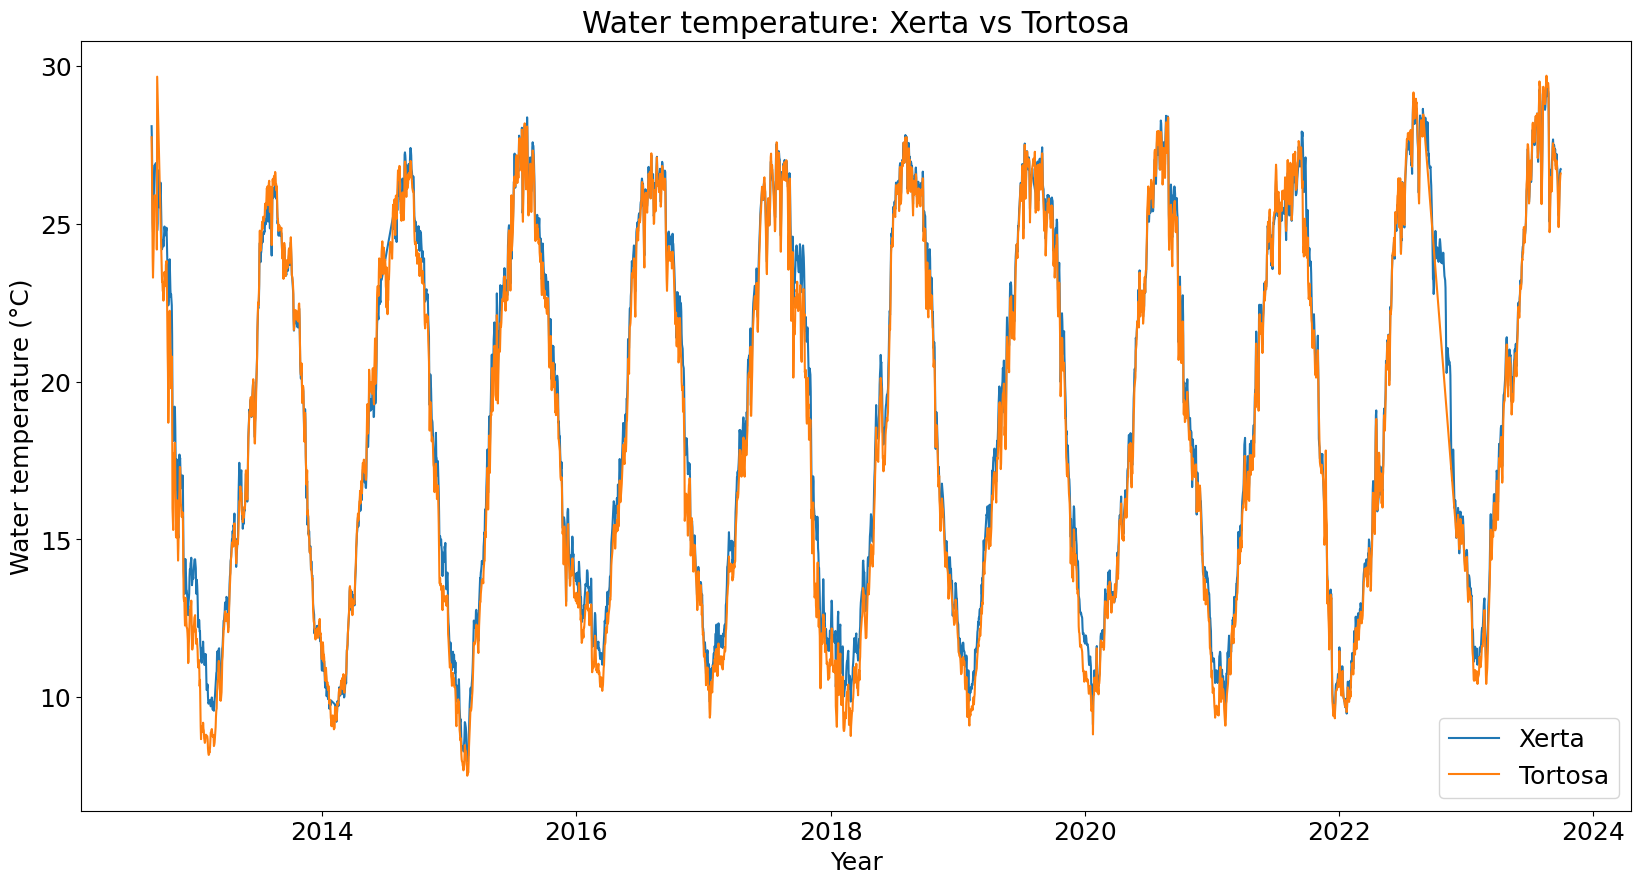

In [23]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=xerta_df, label="Xerta"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)

# add textbox with correlation value
text_string = "\n".join(
    [
        f"Pearson correlation = {value:.4f}",
        f"P-value = {p_value:.4f}",
    ]
)

# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# plt.text(
#     xerta_df["DateTime"].iloc[60],
#     29,
#     s=text_string,
#     fontsize=12,
#     bbox=props,
# )

plt.xlabel("Year")
plt.ylabel("Water temperature (°C)")
plt.title("Water temperature: Xerta vs Tortosa")
plt.show()

### Pearson

In [24]:
pears, _ = stats.pearsonr(
    tortosa_df[common_variable], xerta_df[common_variable]
)

### Cosine Similarity

In [25]:
pairwise.cosine_similarity(
    tortosa_df[common_variable].values.reshape(1, -1),
    xerta_df[common_variable].values.reshape(1, -1),
)

array([[0.99947627]])

### RMSE

In [26]:
rmse = np.sqrt(
    mean_squared_error(
        tortosa_df[common_variable], xerta_df[common_variable]
    )
)
# rmse = rmse / np.std(tortosa_df[common_variable])

### Kendall-Tau

In [27]:
stats.kendalltau(tortosa_df[common_variable], xerta_df[common_variable])

SignificanceResult(statistic=0.9421496993880751, pvalue=0.0)

### Plot

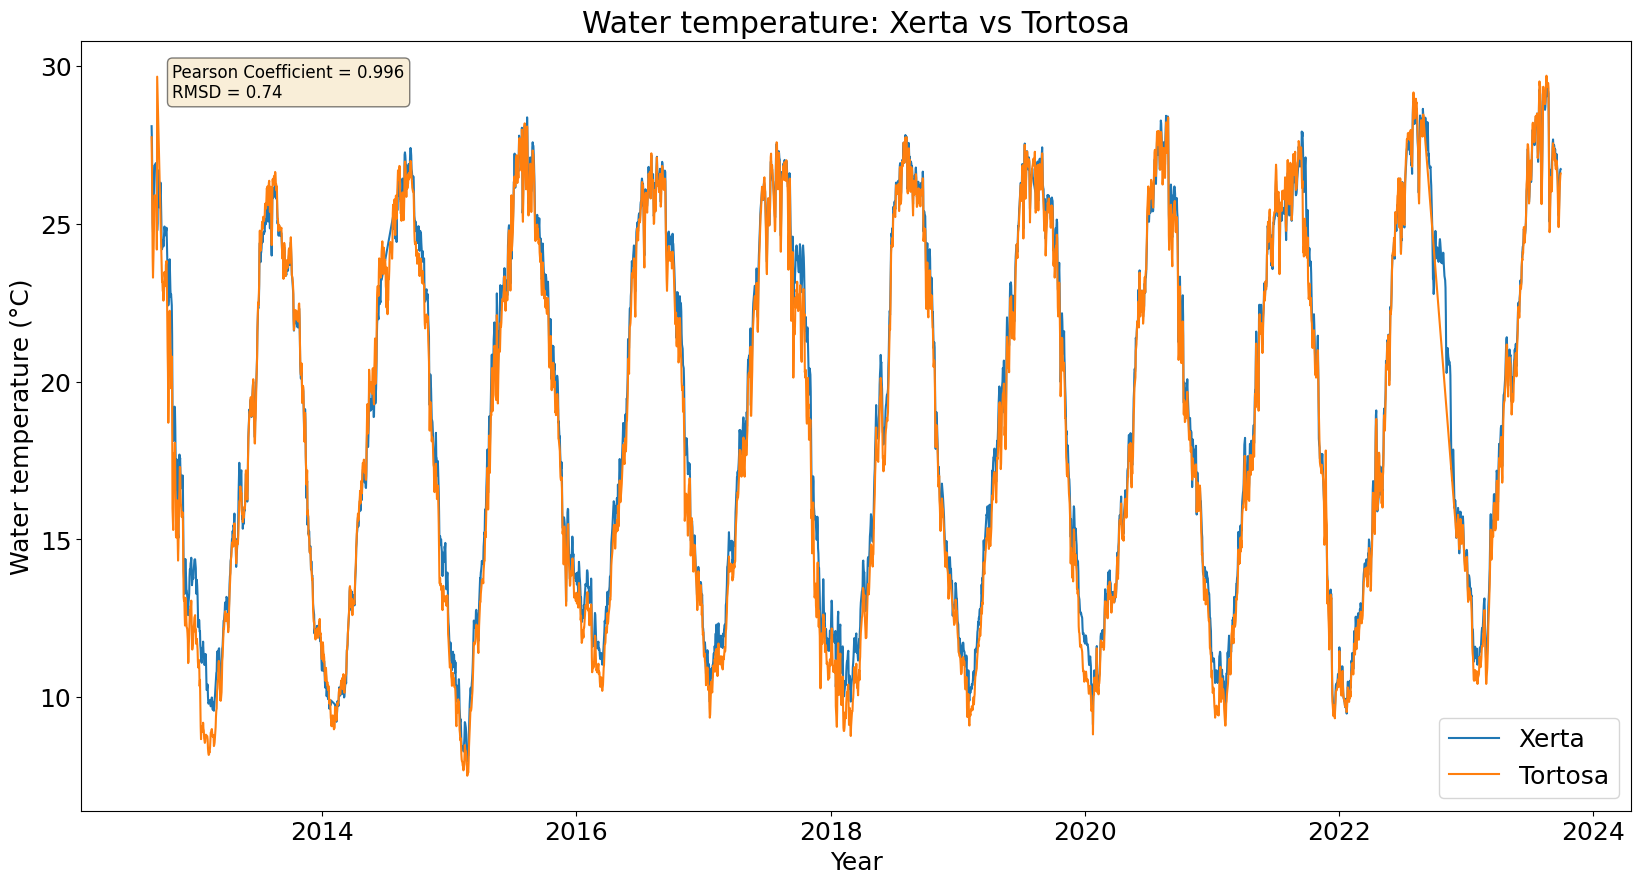

In [28]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=xerta_df, label="Xerta"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)

props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Pearson Coefficient = {pears:.3f}",
        f"RMSD = {rmse:.2f}",
    )
)

plt.text(
    tortosa_df["DateTime"].iloc[60],
    29,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.xlabel("Year")
plt.ylabel("Water temperature (°C)")
plt.title("Water temperature: Xerta vs Tortosa")
plt.show()

## Conductivity

In [29]:
common_variable = "conductivity"

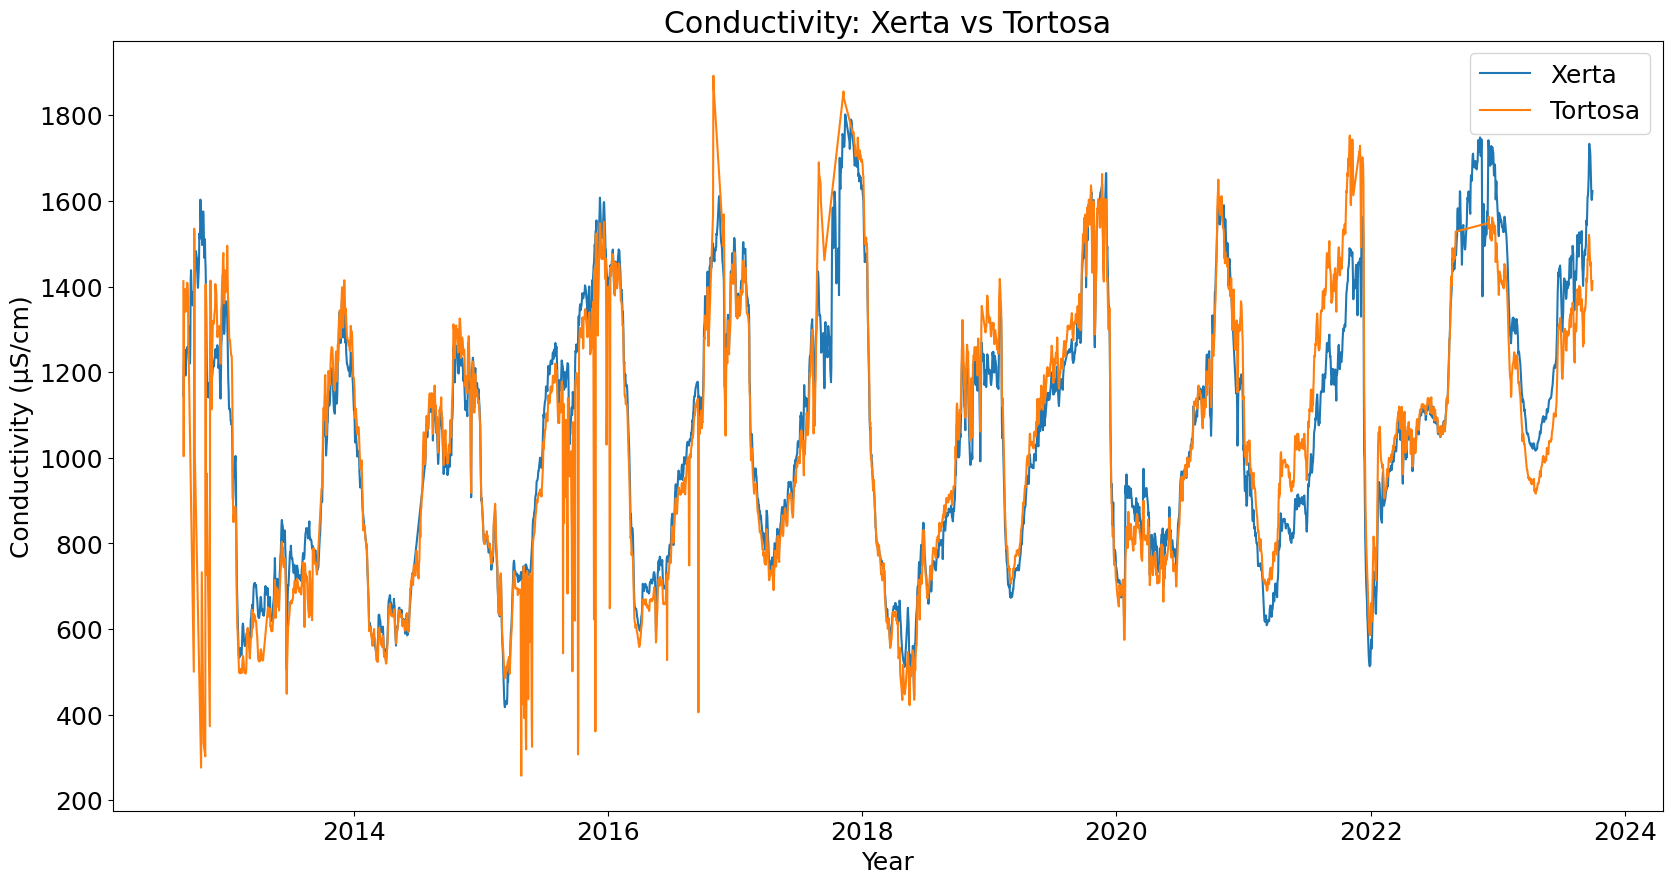

In [30]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=xerta_df, label="Xerta"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)

plt.xlabel("Year")
plt.ylabel("Conductivity (µS/cm)")
plt.title("Conductivity: Xerta vs Tortosa")
plt.show()

### Pearson

In [31]:
pears, _ = stats.pearsonr(
    tortosa_df[common_variable], xerta_df[common_variable]
)

### Cosine Similarity

In [32]:
pairwise.cosine_similarity(
    tortosa_df[common_variable].values.reshape(1, -1),
    xerta_df[common_variable].values.reshape(1, -1),
)

array([[0.99219035]])

### RMSE

In [33]:
rmse = np.sqrt(
    mean_squared_error(
        tortosa_df[common_variable], xerta_df[common_variable]
    )
)
# rmse = rmse / np.std(tortosa_df[common_variable])

### Kendall-Tau

In [34]:
stats.kendalltau(tortosa_df[common_variable], xerta_df[common_variable])

SignificanceResult(statistic=0.8128756500784938, pvalue=0.0)

### Plot

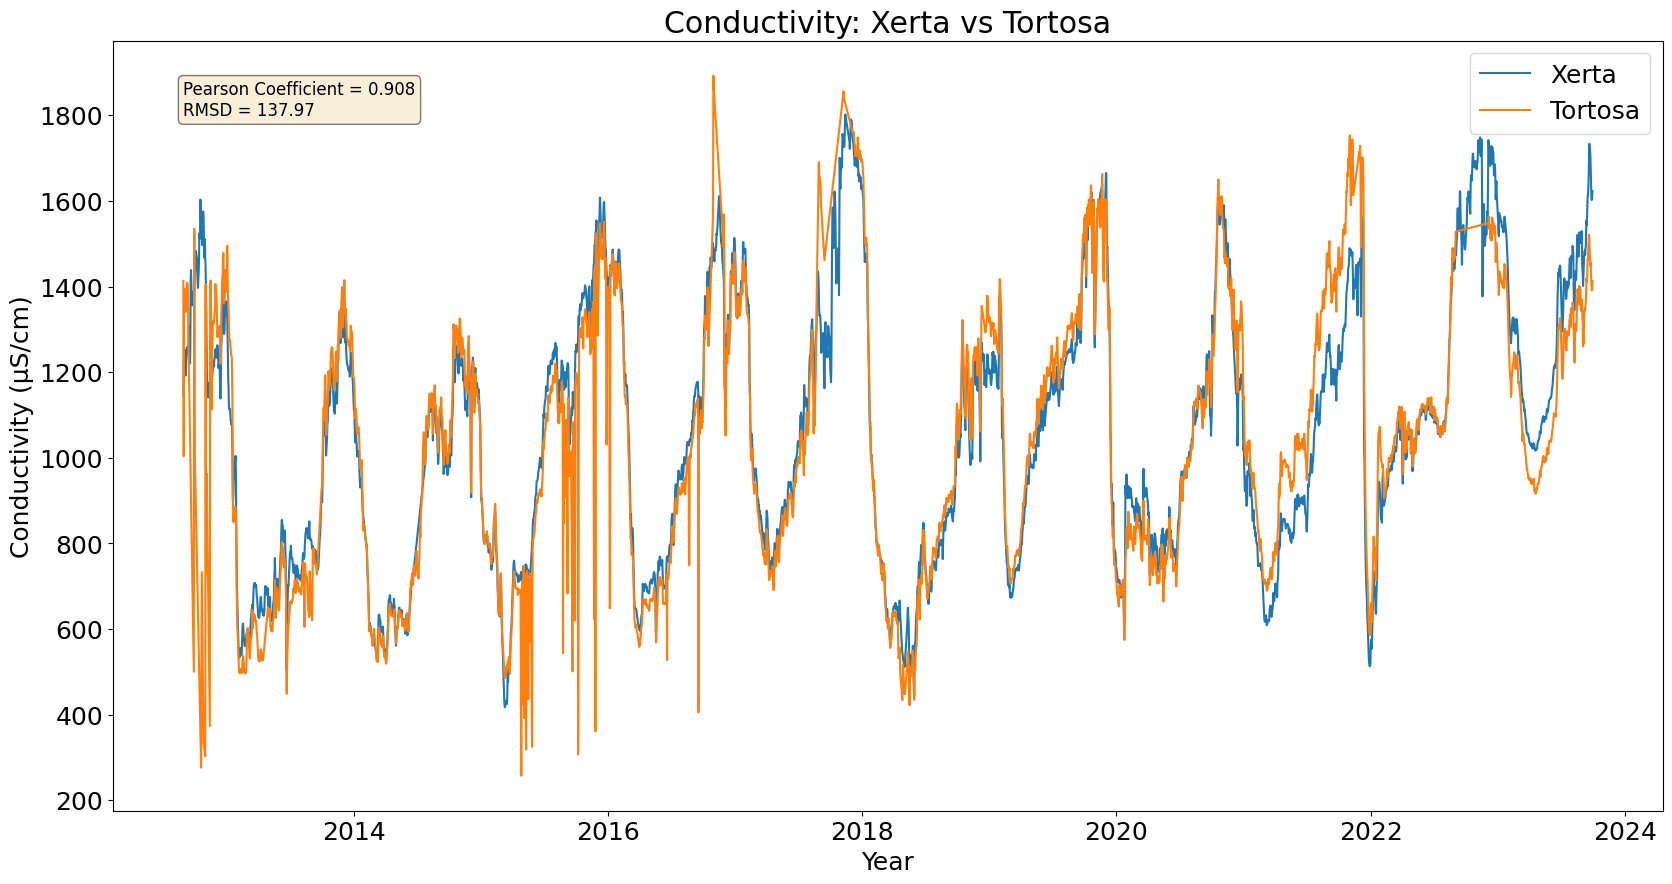

In [35]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=xerta_df, label="Xerta"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)

props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Pearson Coefficient = {pears:.3f}",
        f"RMSD = {rmse:.2f}",
    )
)

plt.text(
    tortosa_df["DateTime"].iloc[0],
    1800,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.xlabel("Year")
plt.ylabel("Conductivity (µS/cm)")
plt.title("Conductivity: Xerta vs Tortosa")
plt.show()

## Turbidity

In [36]:
common_variable = "turbidity"

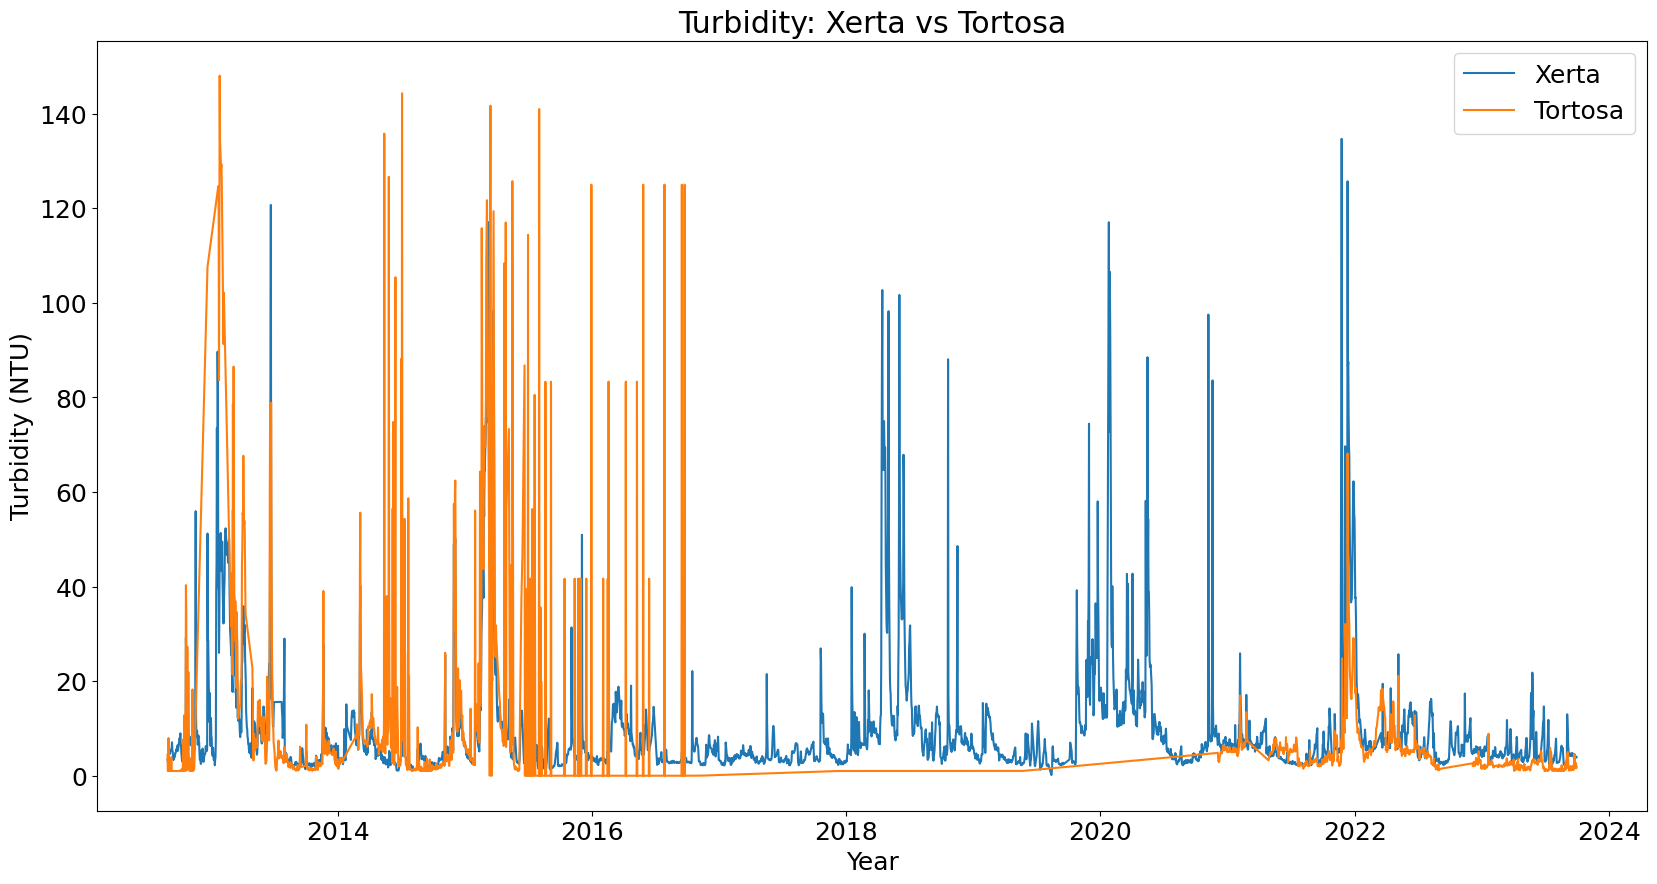

In [37]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=xerta_df, label="Xerta"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)

plt.xlabel("Year")
plt.ylabel("Turbidity (NTU)")
plt.title("Turbidity: Xerta vs Tortosa")
plt.show()

### Pearson

In [38]:
pears, _ = stats.pearsonr(
    tortosa_df[common_variable], xerta_df[common_variable]
)

### Cosine Similarity

In [39]:
pairwise.cosine_similarity(
    tortosa_df[common_variable].values.reshape(1, -1),
    xerta_df[common_variable].values.reshape(1, -1),
)

array([[0.50824118]])

### RMSE

In [40]:
rmse = np.sqrt(
    mean_squared_error(
        tortosa_df[common_variable], xerta_df[common_variable]
    )
)
# rmse / np.std(tortosa_df[common_variable])

### Kendall-Tau

In [41]:
stats.kendalltau(tortosa_df[common_variable], xerta_df[common_variable])

SignificanceResult(statistic=0.22369110789201288, pvalue=3.9094716482095765e-98)

### Plot

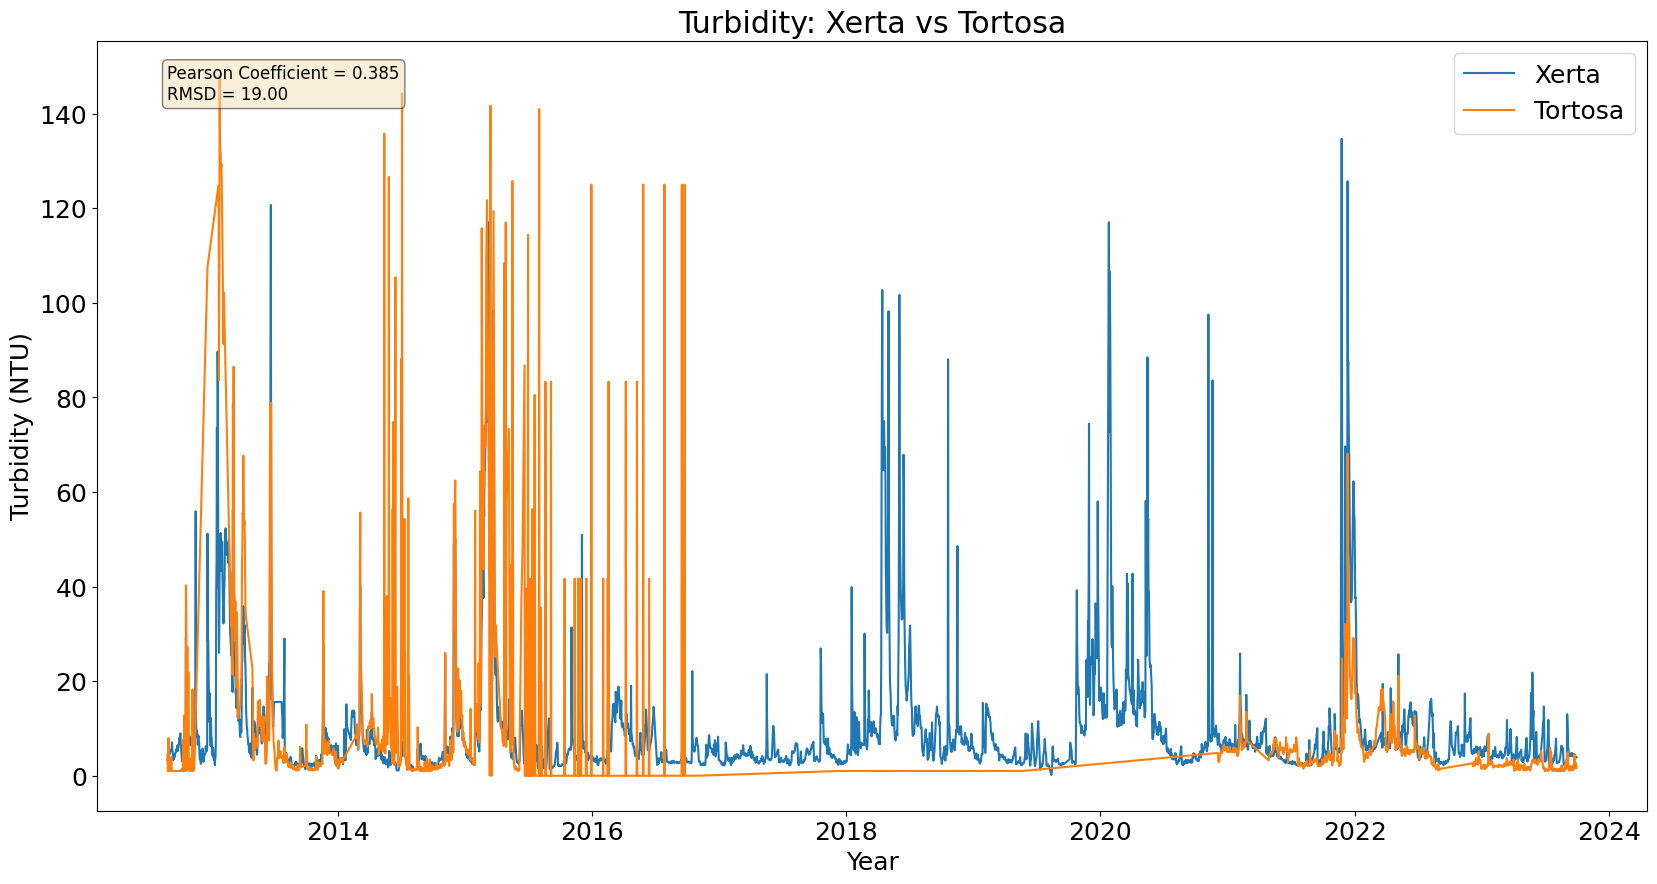

In [42]:
plt.figure()
sns.lineplot(
    x="DateTime", y=common_variable, data=xerta_df, label="Xerta"
)
sns.lineplot(
    x="DateTime", y=common_variable, data=tortosa_df, label="Tortosa"
)

props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Pearson Coefficient = {pears:.3f}",
        f"RMSD = {rmse:.2f}",
    )
)

plt.text(
    tortosa_df["DateTime"].iloc[0],
    143,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.xlabel("Year")
plt.ylabel("Turbidity (NTU)")
plt.title("Turbidity: Xerta vs Tortosa")
plt.show()

## Compute Correlation Matrix

In [43]:
common_variables = {
    "conductivity": "Conductivity\n(µS/cm)",
    "turbidity": "Turbidity\n(NTU)",
    "watertemperature": "Water Temperature\n(°C)",
}
# rename columns

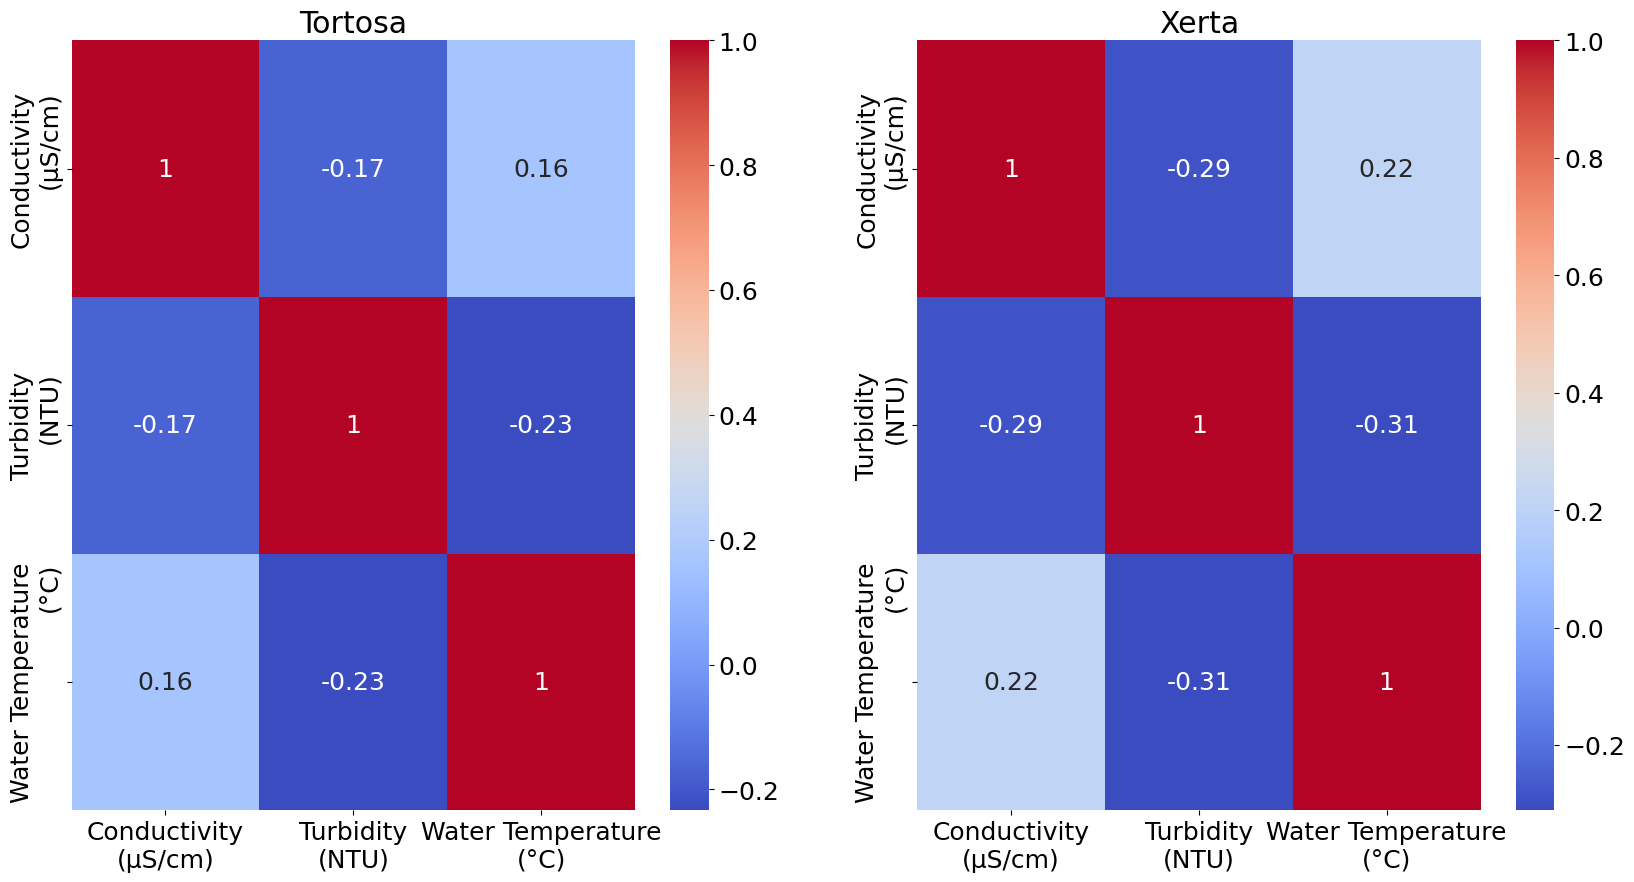

In [44]:
# sort columns
tortosa_corr = tortosa_df[tortosa_df.columns.difference(["DateTime"])][
    common_variables.keys()
].corr()
xerta_corr = xerta_df[xerta_df.columns.difference(["DateTime"])][
    common_variables.keys()
].corr()

# rename columns to common_variables values
tortosa_corr = tortosa_corr.rename(
    columns=common_variables, index=common_variables
)
xerta_corr = xerta_corr.rename(
    columns=common_variables, index=common_variables
)

fig, ax = plt.subplots(1, 2)

sns.heatmap(tortosa_corr, annot=True, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Tortosa")

# center the axis label

sns.heatmap(xerta_corr, annot=True, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Xerta")


plt.show()

# Build unique dataset

In [45]:
# water temperature and conductivity are better in the xerta dataset so no need to merge with tortosa

# I decided to take the rainfall from tortosa since it is the closest to the xerta station

xerta_df["cumulated_rainfall_24h"] = tortosa_df[
    "cumulated_rainfall_24h"
].values
xerta_df["environment_temperature"] = guiamets_df[
    "environmental_temperature"
].values
xerta_df["flowriver"] = tortosa_df["flowriver"].values

xerta_df.rename(
    columns={
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "watertemperature": "Water Temperature",
        "environment_temperature": "Air Temperature",
        "flowriver": "Flow River",
        "conductivity": "Conductivity",
        "dissolvedoxygen": "Dissolved Oxygen",
        "nitrate": "Nitrate",
        "redoxpotential": "Redox Potential",
        "turbidity": "Turbidity",
        "Ammonium": "Ammonium",
        "ABS254": "Absorbance 254nm",
    },
    inplace=True,
)

In [46]:
# drop first 3 rows of xerta_df since they are the only rows for august 2012
xerta_df = xerta_df.iloc[3:]

In [47]:
xerta_df.set_index("DateTime", inplace=True)

In [48]:
# add unit of measurement to the columns
xerta_df.rename(
    columns={
        "Daily Cumulated Rainfall": "Daily Cumulated Rainfall (L/m²)",
        "Water Temperature": "Water Temperature (°C)",
        "Air Temperature": "Air Temperature (°C)",
        "Flow River": "Flow River (m³/s)",
        "Conductivity": "Conductivity (µS/cm)",
        "Dissolved Oxygen": "Dissolved Oxygen (mg/L)",
        "Nitrate": "Nitrate (mg/L)",
        "Redox Potential": "Redox Potential (mV)",
        "Turbidity": "Turbidity (NTU)",
        "Ammonium": "Ammonium (mg/L)",
        "Absorbance 254nm": "Absorbance 254nm (un.Abs/m)",
    },
    inplace=True,
)

In [49]:
xerta_df.to_excel(os.path.join(clean_data_folder, "full_dataset.xlsx"))

# Overall timeseries decomposition

In [ ]:
min_date = xerta_df.index.min()
max_date = xerta_df.index.max()

print("Min date:", min_date)
print("Max date:", max_date)

In [ ]:
# compute time difference between min and max date of the dataset in years
time_diff = xerta_df.index.max() - xerta_df.index.min()
time_diff.total_seconds() / (60 * 60 * 24 * 365)

In [ ]:
for feature in xerta_df.columns.difference(["DateTime"]):
    result = smt.STL(xerta_df[feature], period=365).fit()
    fig, axs = plt.subplots(4, 1, figsize=(40, 20))
    sns.lineplot(data=result.observed, ax=axs[0])
    sns.lineplot(data=result.trend, ax=axs[1])
    sns.lineplot(data=result.seasonal, ax=axs[2])
    sns.lineplot(data=result.resid, ax=axs[3])
    fig.suptitle(feature)

# Yearly Seasonal Decomposition

Every variables seems to have a yearly seasonal component, so the analysis is performed year-by-year.

In [ ]:
xerta_df["month"] = xerta_df.index.month
xerta_df["year"] = xerta_df.index.year
monthly_average = xerta_df.groupby(["year", "month"]).mean()

In [ ]:
monthly_average.reset_index(inplace=True)

In [ ]:
monthly_average["DateTime"] = pd.to_datetime(
    monthly_average[["year", "month"]].assign(day=1)
)
monthly_average.drop(columns=["year", "month"], inplace=True)
monthly_average.set_index("DateTime", inplace=True)

In [ ]:
xerta_df = monthly_average

In [ ]:
rgb = (200, 2, 110)
color = tuple(map(lambda x: x / 255, rgb))

In [ ]:
trend_results = {}


years = xerta_df.index.year.unique()
for year in years:
    trend_results[year] = {}


# year by year extrapolate the trend
# for year in years:
#     trend_results[year] = {}
#     df_year = xerta_df[xerta_df.index.year == year]
#     for feature in xerta_df.columns.difference(["DateTime"]):
#         result = smt.seasonal_decompose(df_year[feature], period=30)
#         trend_results[year][feature] = result.trend.dropna()


for feature in xerta_df.columns.difference(["DateTime"]):
    result = smt.STL(xerta_df[feature], period=12).fit()
    trend = result.trend.dropna()
    for year in years:
        trend_results[year][feature] = trend[trend.index.year == year]

    plt.figure(figsize=(20, 10))
    sns.lineplot(data=result.trend, linewidth=4.0, color=color)
    sns.lineplot(
        data=xerta_df[feature], linewidth=1.0, color="black", alpha=0.5
    )
    plt.title(str(feature) + " - Trend")
    plt.xlabel("Year")
    plt.ylabel(feature)
    plt.show()

In [ ]:
trends_df = pd.DataFrame(trend_results)

In [ ]:
trends_df

## Linear Estimation with insights

In [ ]:
import statsmodels.api as sm

linear_estimations = {}

for feature, row in trends_df.iterrows():
    linear_estimations[feature] = {}
    for year in trends_df.columns:
        result = sm.OLS(
            row[year].values,
            sm.add_constant(row[year].index.to_julian_date()),
        ).fit()
        # result = stats.linregress(row[year].index.to_julian_date(), row[year].values)
        linear_estimations[feature][year] = result

In [ ]:
# save slope and se for each feature and year
slopes = {}
ses = {}
for feature in linear_estimations:
    slopes[feature] = {}
    ses[feature] = {}
    for year in linear_estimations[feature]:
        slopes[feature][year] = (
            linear_estimations[feature][year].params[1].round(5)
        )
        ses[feature][year] = (
            linear_estimations[feature][year].bse[1].round(5)
        )

slopes_df = pd.DataFrame(slopes)
ses_df = pd.DataFrame(ses)

# create unique table where each entry is a string like 'slope +/- se'
slope_se_df = pd.DataFrame()
for feature in slopes_df:
    slope_se_df[feature] = (
        slopes_df[feature].map(str) + " +/- " + ses_df[feature].map(str)
    )

slope_se_df.to_excel(os.path.join(clean_data_folder, "slope_se.xlsx"))

In [ ]:
for feature in linear_estimations.keys():
    # for each year I have to plot the slope and the intercept with their confidence intervals
    fig, ax = plt.subplots(figsize=(20, 10))
    feature_data = {}
    for year in linear_estimations[feature].keys():
        result = linear_estimations[feature][year]
        intercept, slope = result.params
        beta_0_se, beta_1_se = result.bse
        feature_data[year] = {
            "intercept": intercept,
            "slope": slope,
            "intercept_se": beta_0_se,
            "slope_se": beta_1_se,
        }
    # plot slope and intercept with their confidence intervals
    # as if it is a boxplot
    feature_df = pd.DataFrame(feature_data).T
    feature_df["year"] = feature_df.index
    # add confidence intervals as error bars
    # ax.scatter(feature_df["year"], feature_df["slope"], color="black")
    ax.errorbar(
        feature_df["year"],
        feature_df["slope"],
        yerr=feature_df["slope_se"] * 2,
        color="red",
        linestyle="None",
    )
    sns.lineplot(
        data=feature_df,
        x="year",
        y="slope",
        ax=ax,
        marker="o",
        markersize=10,
        linestyle="--",
    )
    ax.set_ylabel("Average Variation (unit/day)")

    # plot horizontal line at 0
    ax.axhline(0, color="red", linestyle="--")

    # add every year to the x axis
    ax.set_xticks(feature_df["year"])
    ax.set_xticklabels(feature_df["year"])
    ax.set_xlabel("Year")

    plt.title(feature + " - Daily Variation per Year")

    plt.show()

## Daily time period

In [ ]:
# plot each trend of each variable for each year
from seaborn import color_palette
import matplotlib.ticker as ticker


for index, row in trends_df.iterrows():
    fig, ax = plt.subplots(figsize=(30, 20))
    fig.set_facecolor("black")
    ax.set_facecolor("black")
    ax.grid(True, linestyle="--", alpha=0.6)
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels(
    #     [
    #         "January",
    #         "February",
    #         "March",
    #         "April",
    #         "May",
    #         "June",
    #         "July",
    #         "August",
    #         "September",
    #         "October",
    #         "November",
    #         "December",
    #     ],
    # )
    ax.yaxis.label.set_color("white")
    ax.yaxis.set_major_locator(ticker.MaxNLocator(20))
    ax.tick_params(axis="y", colors="white")
    ax.tick_params(axis="x", colors="white")

    for column in trends_df.columns:
        color = color_palette("Set3", trends_df.columns.size)[
            trends_df.columns.get_loc(column)
        ]
        sns.lineplot(
            # NB: month performs the mean of every month
            # dayofyear plots every point
            x=row[column].index.dayofyear,
            y=row[column].values,
            linewidth=2.0,
            color=color,
            # marker="o",
            # markersize=10,
            ax=ax,
        )
        # Add a dotted line at the end of each line
        # NB: if dayofyear, change x_start to row[column].index.dayofyear[0]
        # and y_start to row[column].values[0]
        # else x_start = row[column].index.month[0] and y_start = row[column].groupby(row[column].index.month).mean().values[0]

        x_start = row[column].index.dayofyear[0]
        y_start = row[column].values[0]
        x_end = x_start - 1
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # start line label
        ax.text(
            x_end - 10,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

        # NB: if dayofyear, change x_start to row[column].index.dayofyear[-1]
        # and y_start to row[column].values[-1]
        # else x_start = row[column].index.month[-1] and y_start = row[column].groupby(row[column].index.month).mean().values[-1]

        x_start = row[column].index.dayofyear[-1]
        y_start = row[column].values[-1]
        x_end = x_start + 1
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # end line label
        ax.text(
            x_end,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

    plt.xlabel("Day", color="white")
    plt.ylabel("Trend", color="white")
    plt.title(str(index), fontsize=20, weight="bold", color="white")

## Monthly time period

In [ ]:
# plot each trend of each variable for each year
from seaborn import color_palette
import matplotlib.ticker as ticker


for index, row in trends_df.iterrows():
    fig, ax = plt.subplots(figsize=(30, 20))
    fig.set_facecolor("black")
    ax.set_facecolor("black")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(
        [
            "January",
            "February",
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
        ],
    )
    ax.yaxis.label.set_color("white")
    ax.yaxis.set_major_locator(ticker.MaxNLocator(20))
    ax.tick_params(axis="y", colors="white")
    ax.tick_params(axis="x", colors="white")

    for column in trends_df.columns:
        color = color_palette("Set3", trends_df.columns.size)[
            trends_df.columns.get_loc(column)
        ]
        sns.lineplot(
            # NB: month performs the mean of every month
            # dayofyear plots every point
            x=row[column].index.month,
            y=row[column].values,
            linewidth=2.0,
            color=color,
            marker="o",
            markersize=10,
            ax=ax,
        )
        # Add a dotted line at the end of each line
        # NB: if dayofyear, change x_start to row[column].index.dayofyear[0]
        # and y_start to row[column].values[0]
        # else x_start = row[column].index.month[0] and y_start = row[column].groupby(row[column].index.month).mean().values[0]

        x_start = row[column].index.month[0]
        y_start = (
            row[column]
            .groupby(row[column].index.month)
            .mean()
            .values[0]
        )
        x_end = x_start - 0.5
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # start line label
        ax.text(
            x_end - 0.3,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

        # NB: if dayofyear, change x_start to row[column].index.dayofyear[-1]
        # and y_start to row[column].values[-1]
        # else x_start = row[column].index.month[-1] and y_start = row[column].groupby(row[column].index.month).mean().values[-1]

        x_start = row[column].index.month[-1]
        y_start = (
            row[column]
            .groupby(row[column].index.month)
            .mean()
            .values[-1]
        )
        x_end = x_start + 0.5
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # end line label
        ax.text(
            x_end,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

    plt.xlabel("Month", color="white")
    plt.ylabel("Trend", color="white")
    plt.title(str(index), fontsize=20, weight="bold", color="white")

## Combine Trends

In [ ]:
rgb = (200, 2, 110)
color = tuple(map(lambda x: x / 255, rgb))

for feature, row in trends_df.iterrows():
    plt.figure(figsize=(20, 10))
    for column in trends_df.columns:
        sns.lineplot(
            data=row[column],
            linewidth=4.0,
            color=color,
        )
    sns.lineplot(
        data=xerta_df[feature], linewidth=1.0, color="black", alpha=0.5
    )

    # result = smt.STL(xerta_df[feature], period=365).fit()
    # sns.lineplot(data=result.trend + 0.1, linewidth=2.0, color="red")

    plt.title(str(feature) + " - Trend")
    plt.xlabel("Year")
    plt.ylabel(feature)

    plt.show()

## Statistical Tests on trends

### Kruskal-Wallis Test on Trends

In [ ]:
# Pairwise year comparison of the trends
pairwise_kw_results = {}
for feature, row in trends_df.iterrows():
    pairwise_kw_results[feature] = {}
    # compute the Kruskal-Wallis H-test for every pair of years
    df = pd.DataFrame(
        columns=trends_df.columns, index=trends_df.columns
    )
    for year1 in trends_df.columns:
        for year2 in trends_df.columns:
            if year1 != year2:
                stat, p = stats.kruskal(row[year1], row[year2])
                df.loc[year1, year2] = (stat, p)
    pairwise_kw_results[feature] = df

In [ ]:
pairwise_kw_results["Water Temperature (°C)"]

In [ ]:
# overall Kruskal-Wallis H-test for each feature
overall_kw_results = {}
for feature, row in trends_df.iterrows():
    stat, p = stats.kruskal(*[row[year] for year in trends_df.columns])
    overall_kw_results[feature] = (stat, p)

In [ ]:
overall_kw_results_df = pd.DataFrame(overall_kw_results).T

### Dunn Test

In [ ]:
import scikit_posthocs as sp

#### Trend

In [ ]:
trend_dunn_results = {}

for feature, row in trends_df.iterrows():
    result_df = sp.posthoc_dunn(row.to_list(), p_adjust="holm")
    result_df.columns = trends_df.columns
    result_df.index = trends_df.columns
    trend_dunn_results[feature] = result_df

In [ ]:
trend_dunn_results["Absorbance 254nm (un.Abs/m)"]

In [ ]:
for feature, df in trend_dunn_results.items():
    plt.figure(figsize=(30, 15))

    # Create a mask for values > 0.05
    mask = df <= 0.05

    sns.heatmap(df, annot=True, cmap="coolwarm", center=0, mask=mask)
    plt.title(feature)

#### Data

In [ ]:
data_dunn_results = {}
for feature in xerta_df.columns.difference(["DateTime"]):
    # split the data for each year
    data = []
    for year in years:
        data.append(xerta_df[feature][xerta_df.index.year == year])
    result_df = sp.posthoc_dunn(data, p_adjust="holm")
    result_df.columns = years
    result_df.index = years
    data_dunn_results[feature] = result_df

In [ ]:
data_dunn_results["Absorbance 254nm (un.Abs/m)"]

In [ ]:
for feature, df in data_dunn_results.items():
    plt.figure(figsize=(30, 15))

    # Create a mask for values > 0.05
    mask = df <= 0.05

    sns.heatmap(df, annot=True, cmap="coolwarm", center=0, mask=mask)
    plt.title(feature)

# Monthly Seasonal Decomposition

For completeness, the analysis is performed also month-by-month.

In [ ]:
trend_results = {}

for feature in xerta_df.columns.difference(["DateTime"]):
    result = smt.STL(xerta_df[feature], period=365).fit()
    trend = result.trend.dropna()
    trend_results[feature] = {}
    for year in years:
        # get the months of the year
        months = trend[trend.index.year == year].index.month.unique()
        for month in months:
            trend_results[feature][(year, month)] = trend[
                (trend.index.year == year)
                & (trend.index.month == month)
            ]

In [ ]:
trends_df = pd.DataFrame(trend_results)

In [ ]:
trends_df

## Daily time period

In [ ]:
# plot each trend of each variable for each year
from seaborn import color_palette
import matplotlib.ticker as ticker


for index, row in trends_df.iterrows():
    fig, ax = plt.subplots(figsize=(30, 20))
    fig.set_facecolor("black")
    ax.set_facecolor("black")
    ax.grid(True, linestyle="--", alpha=0.6)
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels(
    #     [
    #         "January",
    #         "February",
    #         "March",
    #         "April",
    #         "May",
    #         "June",
    #         "July",
    #         "August",
    #         "September",
    #         "October",
    #         "November",
    #         "December",
    #     ],
    # )
    ax.yaxis.label.set_color("white")
    ax.yaxis.set_major_locator(ticker.MaxNLocator(20))
    ax.tick_params(axis="y", colors="white")
    ax.tick_params(axis="x", colors="white")

    for column in trends_df.columns:
        color = color_palette("Set3", trends_df.columns.size)[
            trends_df.columns.get_loc(column)
        ]
        sns.lineplot(
            # NB: month performs the mean of every month
            # dayofyear plots every point
            x=row[column].index.dayofyear,
            y=row[column].values,
            linewidth=2.0,
            color=color,
            # marker="o",
            # markersize=10,
            ax=ax,
        )
        # Add a dotted line at the end of each line
        # NB: if dayofyear, change x_start to row[column].index.dayofyear[0]
        # and y_start to row[column].values[0]
        # else x_start = row[column].index.month[0] and y_start = row[column].groupby(row[column].index.month).mean().values[0]

        x_start = row[column].index.dayofyear[0]
        y_start = row[column].values[0]
        x_end = x_start - 1
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # start line label
        ax.text(
            x_end - 10,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

        # NB: if dayofyear, change x_start to row[column].index.dayofyear[-1]
        # and y_start to row[column].values[-1]
        # else x_start = row[column].index.month[-1] and y_start = row[column].groupby(row[column].index.month).mean().values[-1]

        x_start = row[column].index.dayofyear[-1]
        y_start = row[column].values[-1]
        x_end = x_start + 1
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # end line label
        ax.text(
            x_end,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

    plt.xlabel("Month", color="white")
    plt.ylabel("Trend", color="white")
    plt.title(str(index), fontsize=20, weight="bold", color="white")

## Monthly time period

In [ ]:
# plot each trend of each variable for each year
from seaborn import color_palette
import matplotlib.ticker as ticker


for index, row in trends_df.iterrows():
    fig, ax = plt.subplots(figsize=(30, 20))
    fig.set_facecolor("black")
    ax.set_facecolor("black")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(
        [
            "January",
            "February",
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
        ],
    )
    ax.yaxis.label.set_color("white")
    ax.yaxis.set_major_locator(ticker.MaxNLocator(20))
    ax.tick_params(axis="y", colors="white")
    ax.tick_params(axis="x", colors="white")

    for column in trends_df.columns:
        color = color_palette("Set3", trends_df.columns.size)[
            trends_df.columns.get_loc(column)
        ]
        sns.lineplot(
            # NB: month performs the mean of every month
            # dayofyear plots every point
            x=row[column].index.month,
            y=row[column].values,
            linewidth=2.0,
            color=color,
            marker="o",
            markersize=10,
            ax=ax,
        )
        # Add a dotted line at the end of each line
        # NB: if dayofyear, change x_start to row[column].index.dayofyear[0]
        # and y_start to row[column].values[0]
        # else x_start = row[column].index.month[0] and y_start = row[column].groupby(row[column].index.month).mean().values[0]

        x_start = row[column].index.month[0]
        y_start = (
            row[column]
            .groupby(row[column].index.month)
            .mean()
            .values[0]
        )
        x_end = x_start - 0.5
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # start line label
        ax.text(
            x_end - 0.3,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

        # NB: if dayofyear, change x_start to row[column].index.dayofyear[-1]
        # and y_start to row[column].values[-1]
        # else x_start = row[column].index.month[-1] and y_start = row[column].groupby(row[column].index.month).mean().values[-1]

        x_start = row[column].index.month[-1]
        y_start = (
            row[column]
            .groupby(row[column].index.month)
            .mean()
            .values[-1]
        )
        x_end = x_start + 0.5
        y_end = y_start
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            "--",
            color=color,
            linewidth=2.0,
        )

        # end line label
        ax.text(
            x_end,
            y_end,
            str(column),
            color=color,
            fontsize=14,
            weight="bold",
            va="center",
        )

    plt.xlabel("Month", color="white")
    plt.ylabel("Trend", color="white")
    plt.title(str(index), fontsize=20, weight="bold", color="white")

## Combine Trends

In [ ]:
for feature, row in trends_df.iterrows():
    plt.figure(figsize=(20, 10))
    for column in trends_df.columns:
        sns.lineplot(
            data=row[column],
            linewidth=2.0,
            color="red",
        )
    sns.lineplot(data=xerta_df[feature], linewidth=2.0, color="blue")

    plt.title(feature)

## Statistical Tests on trends

### Kruskal-Wallis Test on Trends

In [ ]:
# Pairwise year comparison of the trends
pairwise_kw_results = {}
for feature, row in trends_df.iterrows():
    pairwise_kw_results[feature] = {}
    # compute the Kruskal-Wallis H-test for every pair of years
    df = pd.DataFrame(
        columns=trends_df.columns, index=trends_df.columns
    )
    for year1 in trends_df.columns:
        for year2 in trends_df.columns:
            if year1 != year2:
                stat, p = stats.kruskal(row[year1], row[year2])
                df.loc[year1, year2] = (stat, p)
    pairwise_kw_results[feature] = df

In [ ]:
pairwise_kw_results["Water Temperature"]

In [ ]:
# overall Kruskal-Wallis H-test for each feature
overall_kw_results = {}
for feature, row in trends_df.iterrows():
    stat, p = stats.kruskal(*[row[year] for year in trends_df.columns])
    overall_kw_results[feature] = (stat, p)

In [ ]:
overall_kw_results_df = pd.DataFrame(overall_kw_results).T

### Dunn Test

In [ ]:
import scikit_posthocs as sp

#### Trend

In [ ]:
trend_dunn_results = {}

for feature, row in trends_df.iterrows():
    result_df = sp.posthoc_dunn(row.to_list(), p_adjust="holm")
    result_df.columns = trends_df.columns
    result_df.index = trends_df.columns
    trend_dunn_results[feature] = result_df

In [ ]:
trend_dunn_results["ABS254"]

In [ ]:
for feature, df in trend_dunn_results.items():
    plt.figure(figsize=(30, 15))

    # Create a mask for values > 0.05
    mask = df <= 0.05

    sns.heatmap(df, annot=True, cmap="coolwarm", center=0, mask=mask)
    plt.title(feature)

#### Data

In [ ]:
data_dunn_results = {}
for feature in xerta_df.columns.difference(["DateTime"]):
    # split the data for each year
    data = []
    for year in years:
        data.append(xerta_df[feature][xerta_df.index.year == year])
    result_df = sp.posthoc_dunn(data, p_adjust="holm")
    result_df.columns = years
    result_df.index = years
    data_dunn_results[feature] = result_df

In [ ]:
data_dunn_results["ABS254"]

In [ ]:
for feature, df in data_dunn_results.items():
    plt.figure(figsize=(30, 15))

    # Create a mask for values > 0.05
    mask = df <= 0.05

    sns.heatmap(df, annot=True, cmap="coolwarm", center=0, mask=mask)
    plt.title(feature)

# Decomposition of diff timeseries

In [ ]:
xerta_diff_df = xerta_df.diff()

In [ ]:
for feature in xerta_diff_df.columns.difference(["DateTime"]):
    result = smt.STL(xerta_diff_df[feature], period=365).fit()
    fig, axs = plt.subplots(4, 1, figsize=(40, 20))
    sns.lineplot(data=result.observed, ax=axs[0])
    sns.lineplot(data=result.trend, ax=axs[1])
    sns.lineplot(data=result.seasonal, ax=axs[2])
    sns.lineplot(data=result.resid, ax=axs[3])
    fig.suptitle(feature)

# Year by Year Correlation

In [ ]:
xerta_df

In [ ]:
xerta_df.rename(
    columns={
        "Daily Cumulated Rainfall (L/m²)": "Daily Cumulated Rainfall (mm)",
    },
    inplace=True,
)

In [ ]:
# perform year by year correlation
correlation_results = {}

for year in xerta_df.index.year.unique():
    correlation_results[year] = {}
    year_df = xerta_df[xerta_df.index.year == year]
    variable_names = year_df.columns.difference(["DateTime"]).to_list()
    corr_matrix = stats.spearmanr(year_df)
    corr_matrix = pd.DataFrame(
        corr_matrix.correlation,
        columns=variable_names,
        index=variable_names,
    )
    correlation_results[year] = corr_matrix

In [ ]:
for year, df in correlation_results.items():
    plt.figure(figsize=(30, 15))
    sns.heatmap(df, annot=True, cmap="coolwarm", center=0)
    plt.title(year)

# Correlation Coefficients Plots

In [ ]:
# for each variable, create a plot with the year by year correlation with the other variables
for variable in xerta_df.columns.difference(["DateTime"]):
    # store the correlation of the variable with the other variables
    other_variables = {}

    for year, df in correlation_results.items():
        # take the correlation of the variable with the other variables
        correlation = df[variable].drop(variable)

        for other_variable, value in correlation.items():
            if other_variable not in other_variables:
                other_variables[other_variable] = []
            # append every year
            other_variables[other_variable].append(value)

    # plot the correlation of the variable with the other variables
    for other_variable, values in other_variables.items():
        plt.figure(figsize=(30, 15))
        sns.lineplot(
            x=years,
            y=values,
            label=other_variable,
            marker="o",
            markersize=10,
            linewidth=2.0,
            linestyle="--",
        )
        # plot horizontal line at 0
        plt.axhline(0, color="red", linestyle="--")
        plt.xlabel("Year")
        plt.ylabel("Spearman Correlation Coefficient")
        plt.title(variable + " - " + "Spearman Correlation by Year")
        # increase the x axis year ticks
        plt.xticks(years)

        # # save the plot to the correlation folder
        # if not os.path.exists(os.path.join(correlation_folder, variable)):
        #     os.makedirs(os.path.join(correlation_folder, variable))
        plt.show()

In [ ]:
# for each variable, create a plot with the year by year correlation with the other variables
variable = "Absorbance 254nm (un.Abs/m)"
# store the correlation of the variable with the other variables
other_variables = {}

skip_variables = [
    "pH",
    "Ammonium (mg/L)",
    "Conductivity (µS/cm)",
    "Dissolved Oxygen (mg/L)",
    "Nitrate (mg/L)",
    "Redox Potential (mV)",
    "Turbidity (NTU)",
    "Conductivity (µS/cm)",
    "Nitrate (mg/L)",
]

for year, df in correlation_results.items():
    # take the correlation of the variable with the other variables
    correlation = df[variable].drop(variable)

    for other_variable, value in correlation.items():
        if other_variable not in skip_variables:
            if other_variable not in other_variables:
                other_variables[other_variable] = []
            # append every year
            other_variables[other_variable].append(value)

plt.figure(figsize=(30, 15))
# plot the correlation of the variable with the other variables
# give me 4 colors
colors = sns.color_palette("Set1", 4)

for other_variable, values in other_variables.items():
    sns.lineplot(
        x=years,
        y=values,
        label=other_variable,
        marker="o",
        markersize=10,
        linewidth=2.0,
        linestyle="--",
        color=colors.pop(0),
    )
# plot horizontal line at 0
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Spearman Correlation Coefficient")
plt.title(variable + " - " + "Spearman Correlation by Year")
# increase the x axis year ticks
plt.xticks(years)

# # save the plot to the correlation folder
# if not os.path.exists(os.path.join(correlation_folder, variable)):
#     os.makedirs(os.path.join(correlation_folder, variable))
plt.show()